In [58]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paramaggarwal_fashion_product_images_small_path = kagglehub.dataset_download('paramaggarwal/fashion-product-images-small')

print('Data source import complete.')


Data source import complete.


In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import warnings

warnings.filterwarnings('ignore')
# pd.set_option('display.max_rows', None)

In [68]:
df = pd.read_csv(paramaggarwal_fashion_product_images_small_path+'/styles.csv', on_bad_lines='skip')

In [69]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


### EDA and Pre-processing

In [6]:
df.shape

(44424, 10)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [71]:
df.describe()

,id,year
count,44424.000000,44423.000000
mean,29696.334301,2012.806497
std,17049.490518,2.126480
min,1163.000000,2007.000000
25%,14768.750000,2011.000000
50%,28618.500000,2012.000000
75%,44683.250000,2015.000000
max,60000.000000,2019.000000


In [72]:
df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [73]:
# Dropping rows having NaN values since they are quite low in number as compared to the size of the dataset
df = df.dropna().reset_index(drop=True)

In [74]:
# Inspecting the important categorical columns present in the dataset
cat_cols = ['gender', 'masterCategory', 'subCategory', 'articleType', 'season', 'baseColour', 'usage']

for col in cat_cols:
    print(col)
    print(df[col].unique())
    print('------------------------------')


gender
['Men' 'Women' 'Boys' 'Girls' 'Unisex']
------------------------------
masterCategory
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
------------------------------
subCategory
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Scarves' 'Dress' 'Loungewear and Nightwear'
 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup'
 'Free Gifts' 'Ties' 'Accessories' 'Nails' 'Beauty Accessories'
 'Water Bottle' 'Skin' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
------------------------------
articleType
['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' '

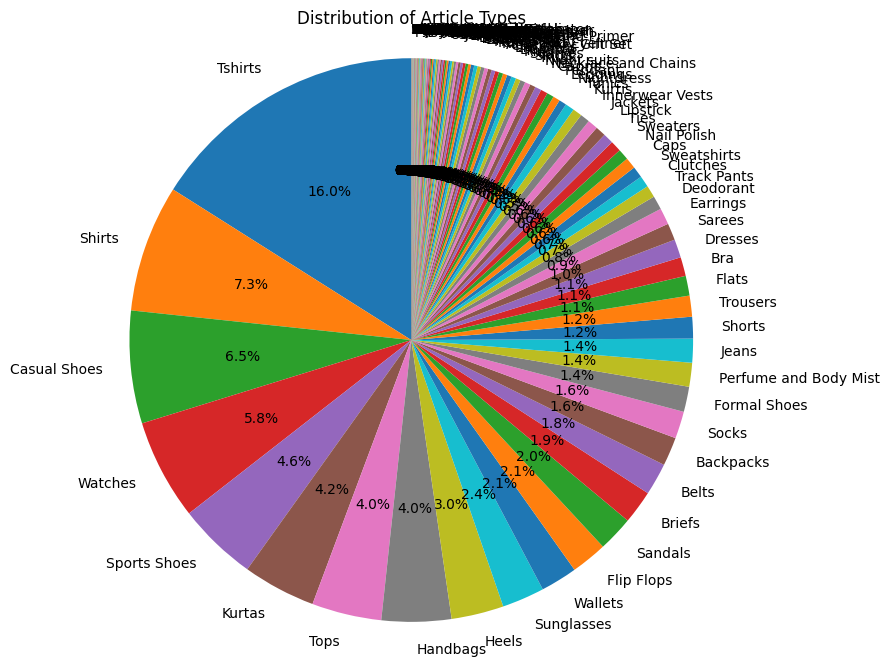

In [85]:
article_type_counts = df['articleType'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(article_type_counts, labels=article_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Article Types')
plt.axis('equal')  
plt.show()

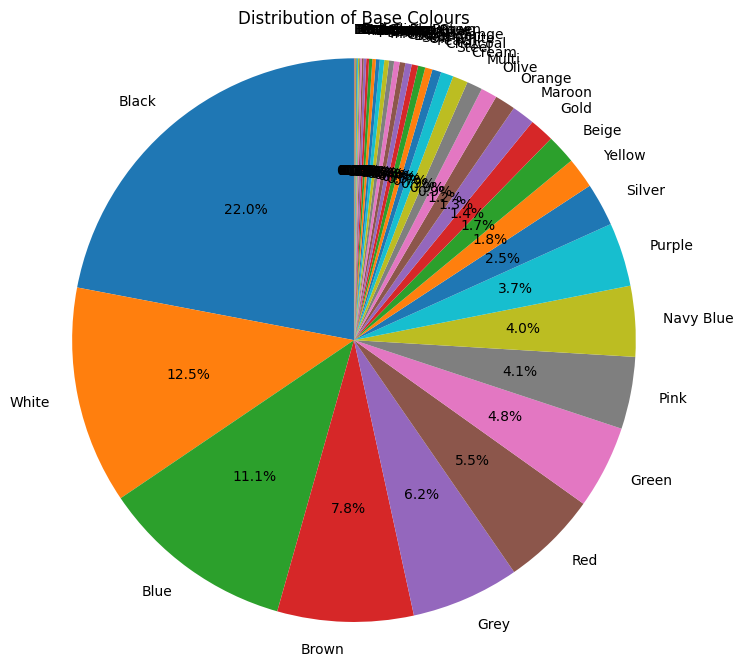

In [84]:
base_colour_counts = df['baseColour'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(base_colour_counts, labels=base_colour_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Base Colours')
plt.axis('equal')  
plt.show()

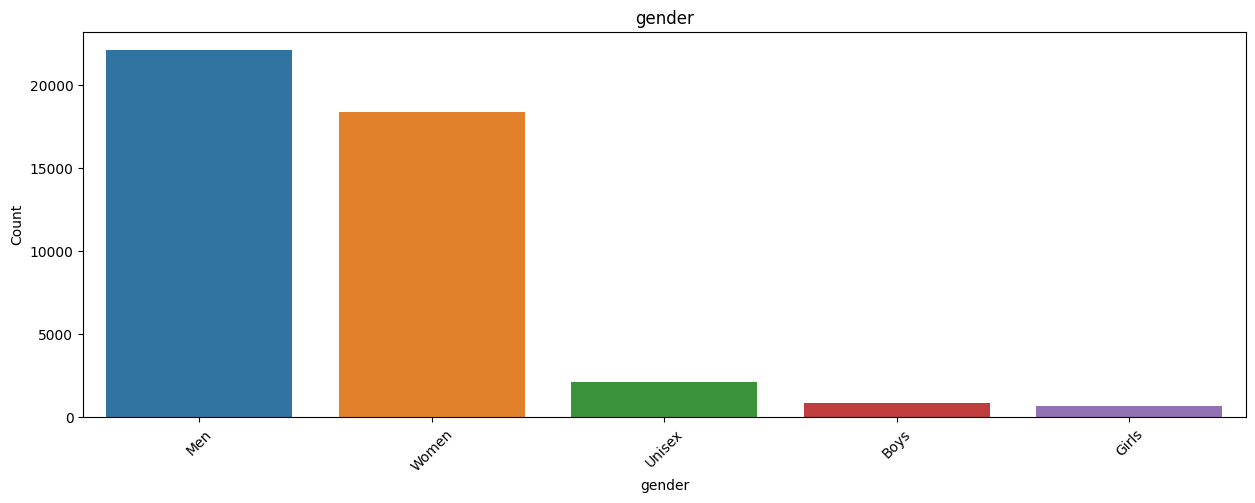

In [80]:
col = 'gender'
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x=col, order=df[col].value_counts().index)
plt.title(col)
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.ylabel('Count')
plt.show()

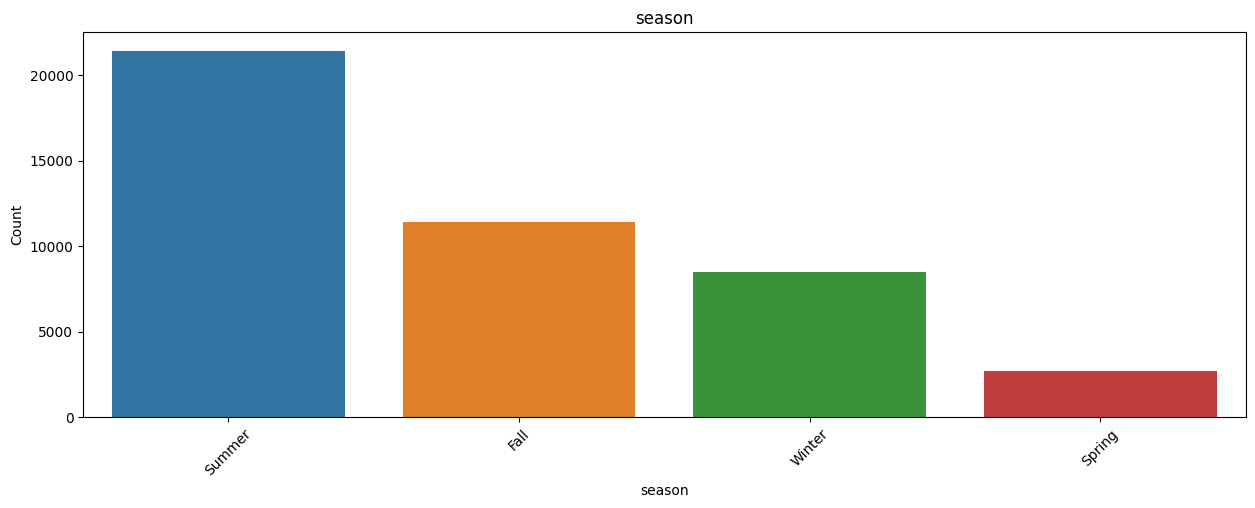

In [81]:
col = 'season'
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x=col, order=df[col].value_counts().index)
plt.title(col)
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.ylabel('Count')
plt.show()

In [86]:
df['gender'].value_counts()

gender
Men       22109
Women     18357
Unisex     2126
Boys        830
Girls       655
Name: count, dtype: int64

As the number of 'boys' and 'girls' is significantly lesser than other categories, we can club them into 'men' and 'women' respectively in order to perform a meaningful analysis

In [87]:
df['gender'].replace({'Boys': 'Men', 'Girls': 'Women'}, inplace=True)

In [13]:
df['gender'].value_counts()

gender
Men       22939
Women     19012
Unisex     2126
Name: count, dtype: int64

In [88]:
df['season'].value_counts()

season
Summer    21440
Fall      11414
Winter     8511
Spring     2712
Name: count, dtype: int64

In [89]:
df['articleType'].value_counts()

articleType
Tshirts                7066
Shirts                 3214
Casual Shoes           2845
Watches                2542
Sports Shoes           2016
                       ... 
Shoe Laces                1
Mens Grooming Kit         1
Body Wash and Scrub       1
Suits                     1
Ipad                      1
Name: count, Length: 142, dtype: int64

In order to do a meaningful analysis, we will only consider those article types which occur more than 200 times in the data

In [90]:
df_filtered = df[df.groupby('articleType')['articleType'].transform('count') > 200]

In [91]:
df_filtered['articleType'].value_counts()

articleType
Tshirts                  7066
Shirts                   3214
Casual Shoes             2845
Watches                  2542
Sports Shoes             2016
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   928
Flip Flops                914
Sandals                   895
Briefs                    847
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     603
Jeans                     603
Shorts                    547
Trousers                  530
Flats                     500
Bra                       477
Dresses                   464
Sarees                    427
Earrings                  416
Deodorant                 347
Track Pants               304
Clutches                  288
Sweatshirts               285
Caps                      283
Nail Polish               27

In [92]:
df_filtered.shape

(40003, 10)

In [93]:
df_filtered['baseColour'].value_counts()

baseColour
Black                9006
White                5214
Blue                 4487
Brown                3221
Grey                 2553
Red                  2246
Green                1936
Navy Blue            1646
Pink                 1579
Purple               1468
Silver                818
Yellow                709
Beige                 676
Maroon                511
Orange                468
Gold                  455
Olive                 367
Multi                 337
Cream                 322
Charcoal              198
Steel                 191
Peach                 157
Off White             151
Lavender              137
Khaki                 133
Grey Melange          115
Magenta               110
Teal                  110
Tan                   109
Mustard                79
Bronze                 73
Copper                 70
Turquoise Blue         56
Rust                   50
Metallic               40
Burgundy               37
Skin                   36
Coffee Brown           26
S

In order to do a meaningful analysis, we will only consider those colors which occur more than 200 times in the data

In [94]:
df_filtered = df_filtered[df_filtered.groupby('baseColour')['baseColour'].transform('count') > 200]

In [95]:
df_filtered.shape

(38019, 10)

The number of classes in each of the four important categorical variables

In [96]:
num_articleType = df_filtered['articleType'].nunique()
num_baseColour = df_filtered['baseColour'].nunique()
num_gender = df_filtered['gender'].nunique()
num_season = df_filtered['season'].nunique()
num_articleType, num_baseColour, num_gender, num_season

(40, 19, 3, 4)

In [97]:
# Label encoding the target columns so that the model can process it

label_columns = ['articleType', 'baseColour', 'gender', 'season']
df_filtered = df_filtered[['id', 'articleType', 'baseColour', 'gender', 'season']]

label_encoders = {}

for col in label_columns:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col])
    label_encoders[col] = le


with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)

In [98]:
## Adding image id column to make use of it while loading the images

df_filtered['image_id'] = df_filtered['id'].apply(lambda x: str(x) + '.jpg')
df_filtered.head()

,id,articleType,baseColour,gender,season,image_id
0,15970,25,10,0,0,15970.jpg
1,39386,17,2,0,2,39386.jpg
2,59263,39,16,2,3,59263.jpg
3,21379,34,1,0,0,21379.jpg
4,53759,36,7,0,2,53759.jpg


## Loading Images using a Custom Data Generator

In [109]:
BASE_IMG_DIR = paramaggarwal_fashion_product_images_small_path + '/images'

def data_generator(generator, dataframe, directory, x_col, y_col, target_size, batch_size, subset):

    data_gen = generator.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='multi_output',
        subset=subset,
        shuffle=True
    )

    while True:
        x_batch, y_batch = next(data_gen)
        # print(type(x_batch), type(y_batch))
        y_tuple =tuple(y_batch[i] for i in range(len(y_batch)))
        yield x_batch, y_tuple

datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.25)

train_generator = data_generator(
    datagen, df_filtered, BASE_IMG_DIR, 'image_id', label_columns,
    target_size=(224, 224), batch_size=32, subset='training'
)

validation_generator = data_generator(
    datagen, df_filtered, BASE_IMG_DIR, 'image_id', label_columns,
    target_size=(224, 224), batch_size=32, subset='validation'
)


## Building and Training the Model

In [110]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

input_layer = Input(shape=(224, 224, 3))

layer_1 = base_model(input_layer)
layer_2 = Flatten()(layer_1)
layer_3 = Dense(512, activation='relu')(layer_2)
layer_4 = Dropout(0.2)(layer_3)

output_articleType = Dense(num_articleType, activation='softmax', name='articleType')(layer_4)
output_baseColour = Dense(num_baseColour, activation='softmax', name='baseColour')(layer_4)
output_gender = Dense(num_gender, activation='softmax', name='gender')(layer_4)
output_season = Dense(num_season, activation='softmax', name='season')(layer_4)

model = Model(inputs=[input_layer], outputs=[output_articleType, output_baseColour, output_gender, output_season])


In [111]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │     12,845,568 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ articleType (Dense)       │ (None, 40)             │         20,520 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ baseColour (Dense)        │ (None, 19)             │          9,747 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 3)              │          1,539 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ season (Dense)            │ (None, 4)              │          2,052 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,594,114 (105.26 MB)

 Trainable params: 12,879,426 (49.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

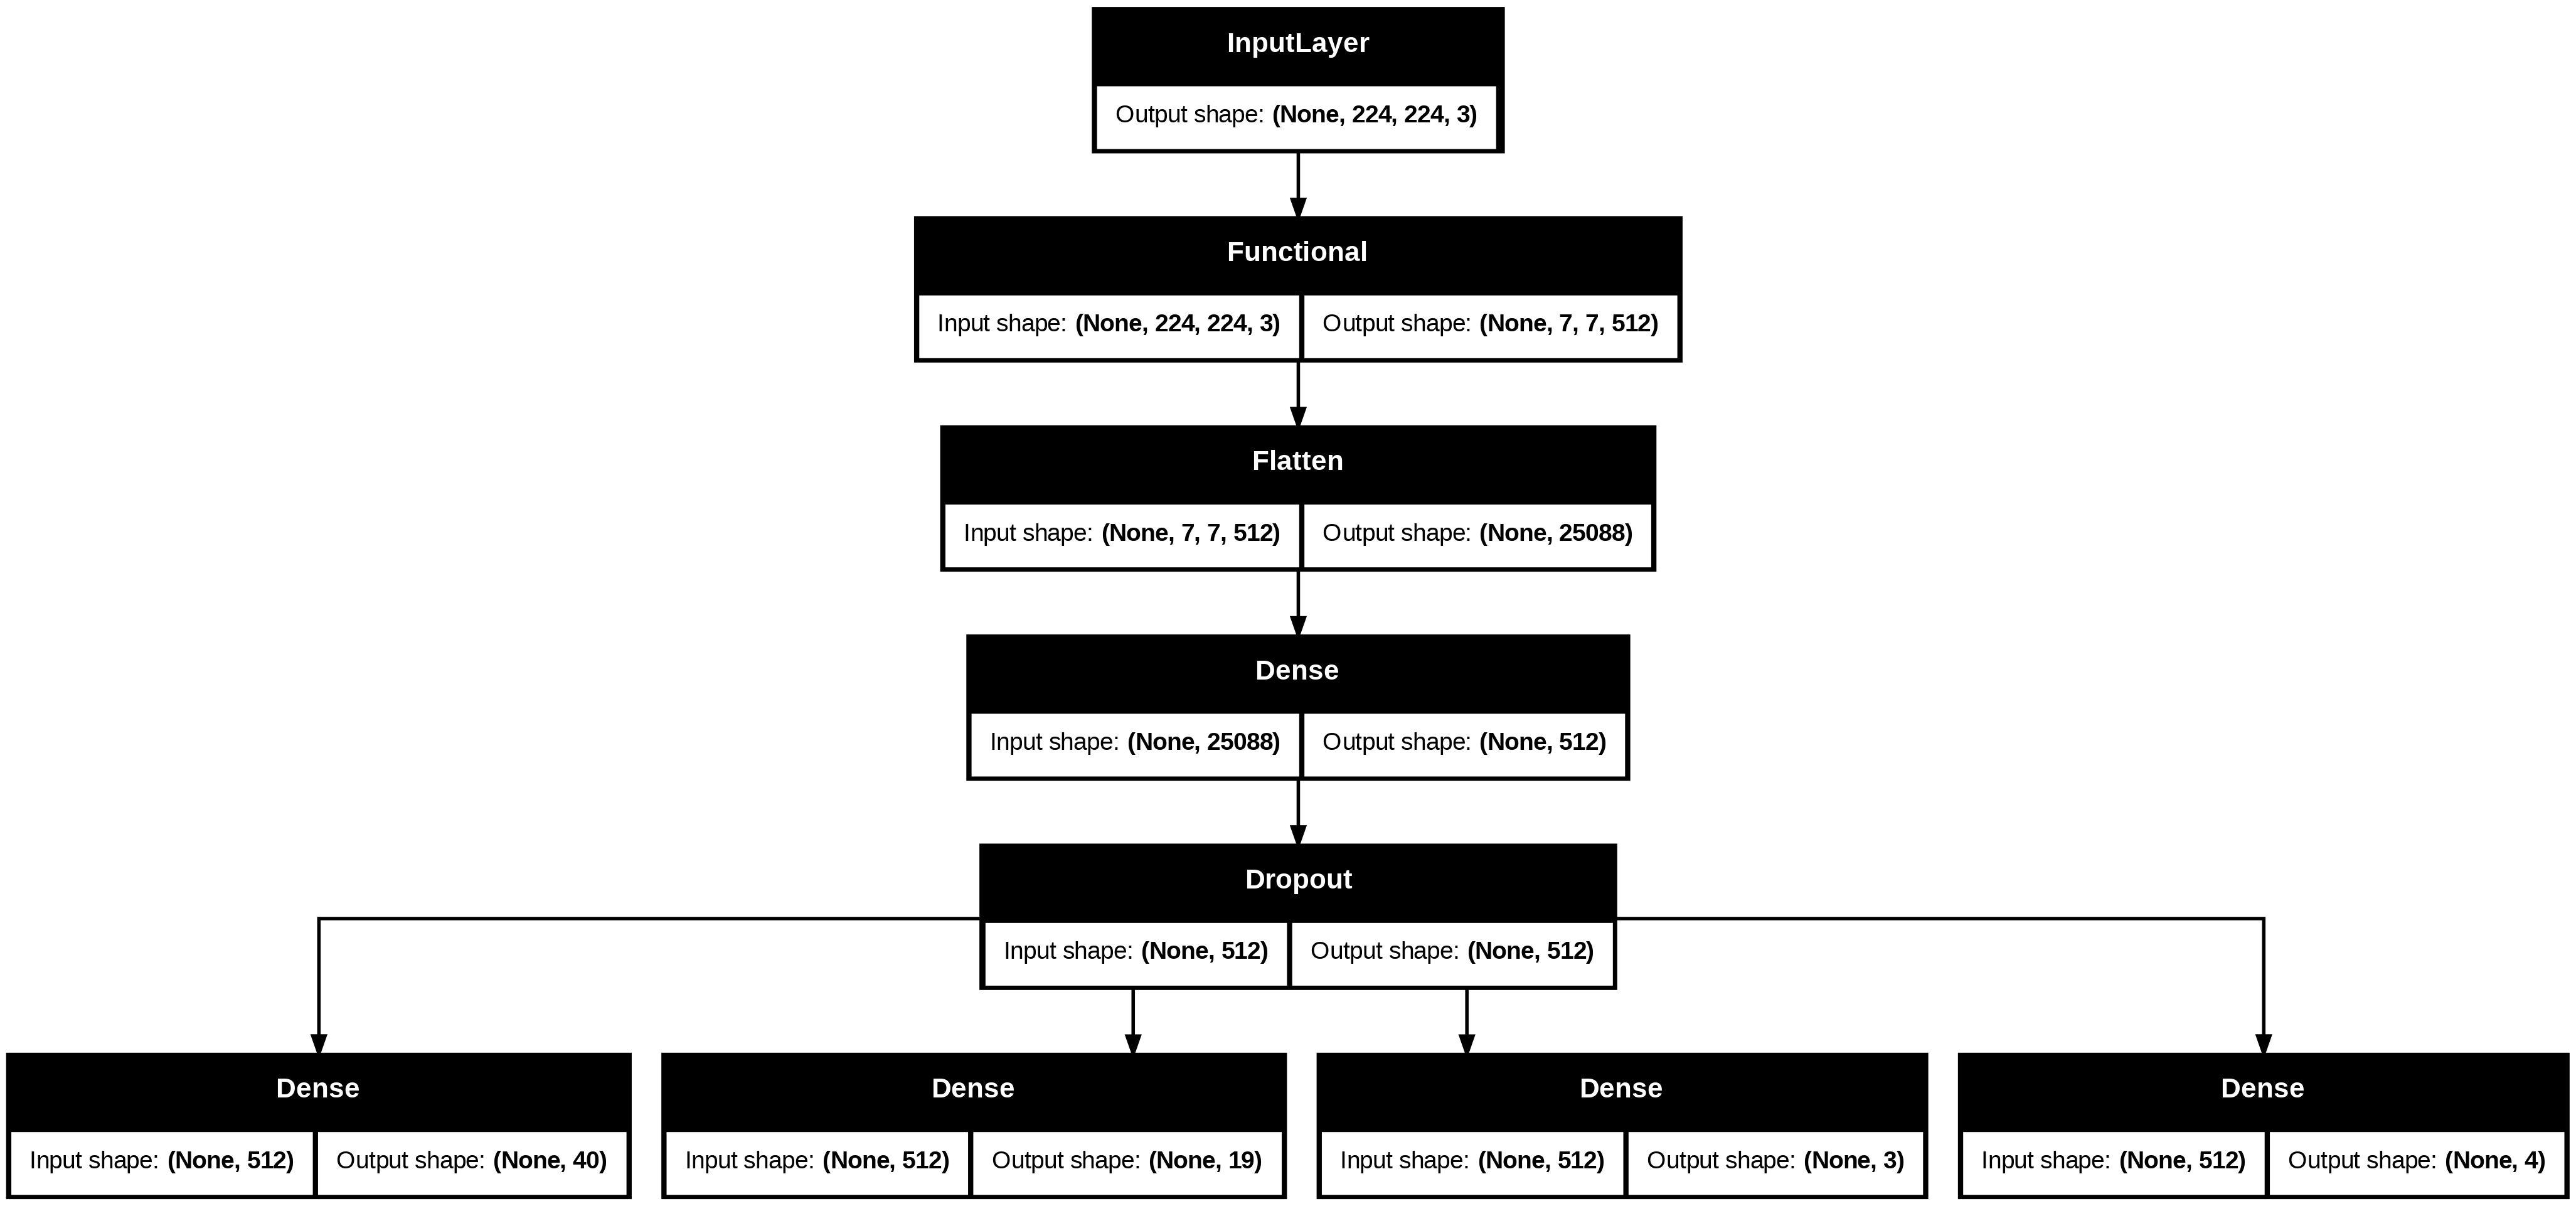

In [101]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [112]:
model.compile(optimizer='adam',
                  loss={'articleType': 'sparse_categorical_crossentropy',
                  'baseColour': 'sparse_categorical_crossentropy',
                  'gender': 'sparse_categorical_crossentropy',
                  'season': 'sparse_categorical_crossentropy'},
                    metrics = ['accuracy', 'accuracy', 'accuracy', 'accuracy'])

In [113]:
train_samples = int(len(df_filtered) * (1 - 0.25))
validation_samples = len(df_filtered) - train_samples
batch_size=32
steps_per_epoch = train_samples // batch_size
validation_steps = validation_samples // batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=2)

history = model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=1, callbacks=[early_stopping], steps_per_epoch=steps_per_epoch, validation_steps=validation_steps )

Found 28512 validated image filenames.
Epoch 1/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - articleType_accuracy: 0.6492 - articleType_loss: 1.4188 - baseColour_accuracy: 0.3440 - baseColour_loss: 2.3062 - gender_accuracy: 0.8116 - gender_loss: 0.6126 - loss: 5.3968 - season_accuracy: 0.6028 - season_loss: 1.0592Found 9503 validated image filenames.
891/891 ━━━━━━━━━━━━━━━━━━━━ 222s 232ms/step - articleType_accuracy: 0.6493 - articleType_loss: 1.4182 - baseColour_accuracy: 0.3441 - baseColour_loss: 2.3059 - gender_accuracy: 0.8116 - gender_loss: 0.6123 - loss: 5.3954 - season_accuracy: 0.6028 - season_loss: 1.0590 - val_articleType_accuracy: 0.8367 - val_articleType_loss: 0.4784 - val_baseColour_accuracy: 0.4941 - val_baseColour_loss: 1.6286 - val_gender_accuracy: 0.8937 - val_gender_loss: 0.2926 - val_loss: 3.1255 - val_season_accuracy: 0.6956 - val_season_loss: 0.7259
Epoch 2/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 185s 208ms/step - articleType_accuracy: 0.8231 - articleType_loss: 0.5304 

In [114]:
model.save('model.h5')

In [115]:
model = load_model('model.h5')

## Model Evaluation on Validation Set

In [116]:
history.history

{'articleType_accuracy': [0.7451950311660767,
  0.8249158263206482,
  0.8428731560707092,
  0.8564814925193787,
  0.8645131587982178,
  0.8751753568649292,
  0.8803310990333557,
  0.8836629986763,
  0.8913440108299255,
  0.8968855142593384],
 'articleType_loss': [0.8955238461494446,
  0.5211685299873352,
  0.46162328124046326,
  0.4146044850349426,
  0.38497766852378845,
  0.3501833975315094,
  0.33448249101638794,
  0.32358747720718384,
  0.2973298132419586,
  0.28091147541999817],
 'baseColour_accuracy': [0.39937570691108704,
  0.480990469455719,
  0.5068041682243347,
  0.5354236960411072,
  0.5489618182182312,
  0.5655162930488586,
  0.5810185074806213,
  0.5947320461273193,
  0.6044823527336121,
  0.6174242496490479],
 'baseColour_loss': [2.011462450027466,
  1.6570767164230347,
  1.5579140186309814,
  1.4632259607315063,
  1.3970046043395996,
  1.341994285583496,
  1.2835681438446045,
  1.2392836809158325,
  1.1916964054107666,
  1.1433608531951904],
 'gender_accuracy': [0.8504489

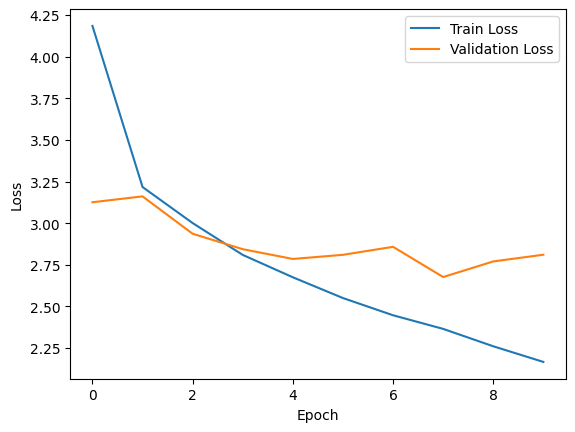

In [117]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

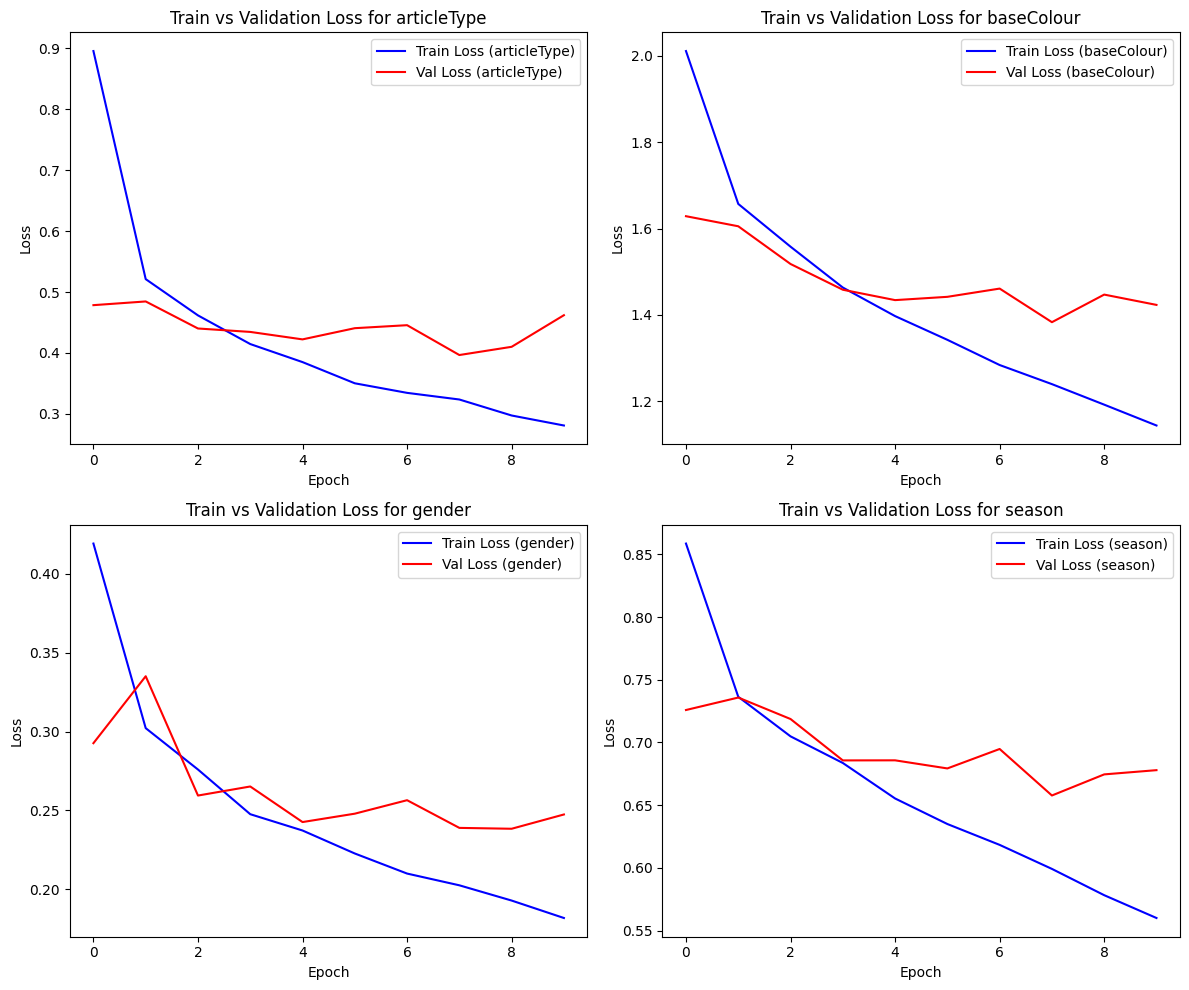

In [126]:
# Train and validation loss plots for each of the output columns

history_dict = history.history

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting train and validation loss for articleType
axes[0, 0].plot(history_dict['articleType_loss'], label='Train Loss (articleType)', color='blue')
axes[0, 0].plot(history_dict['val_articleType_loss'], label='Val Loss (articleType)', color='red')
axes[0, 0].set_title('Train vs Validation Loss for articleType')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plotting train and validation loss for baseColour
axes[0, 1].plot(history_dict['baseColour_loss'], label='Train Loss (baseColour)', color='blue')
axes[0, 1].plot(history_dict['val_baseColour_loss'], label='Val Loss (baseColour)', color='red')
axes[0, 1].set_title('Train vs Validation Loss for baseColour')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Plotting train and validation loss for gender
axes[1, 0].plot(history_dict['gender_loss'], label='Train Loss (gender)', color='blue')
axes[1, 0].plot(history_dict['val_gender_loss'], label='Val Loss (gender)', color='red')
axes[1, 0].set_title('Train vs Validation Loss for gender')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plotting train and validation loss for season
axes[1, 1].plot(history_dict['season_loss'], label='Train Loss (season)', color='blue')
axes[1, 1].plot(history_dict['val_season_loss'], label='Val Loss (season)', color='red')
axes[1, 1].set_title('Train vs Validation Loss for season')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Predictions on Sample Images Taken From the Web

In [51]:
def get_predictions(test_img_path):

    test_img = image.load_img(test_img_path, target_size=(224, 224))
    test_img_array = image.img_to_array(test_img)
    test_img_array = test_img_array / 255.0
    test_img_array = np.expand_dims(test_img_array, axis=0)

    predictions = model.predict(test_img_array)

    articleType_encoder = label_encoders['articleType']
    baseColour_encoder = label_encoders['baseColour']
    gender_encoder = label_encoders['gender']
    season_encoder = label_encoders['season']

    articleType_pred = np.argmax(predictions[0])
    baseColour_pred = np.argmax(predictions[1])
    gender_pred = np.argmax(predictions[2])
    season_pred = np.argmax(predictions[3])
    
    articleType_label = articleType_encoder.inverse_transform([articleType_pred])[0]
    baseColour_label = baseColour_encoder.inverse_transform([baseColour_pred])[0]
    gender_label = gender_encoder.inverse_transform([gender_pred])[0]
    season_label = season_encoder.inverse_transform([season_pred])[0]

    print("Predicted article type:", articleType_label)
    print("Predicted colour:", baseColour_label)
    print("Predicted gender:", gender_label)
    print("Predicted season:", season_label)

    plt.imshow(test_img_array[0])  
    plt.axis('off')  
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted article type: Shorts
Predicted colour: Black
Predicted gender: Women
Predicted season: Summer


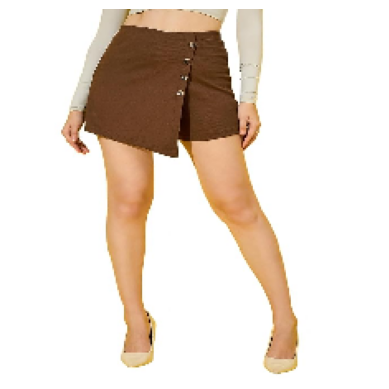

In [52]:
test_img_path = '/kaggle/input/codemonk-test-images/61F3QFc92CL._SY879_.jpg'
get_predictions(test_img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted article type: Tops
Predicted colour: Pink
Predicted gender: Women
Predicted season: Summer


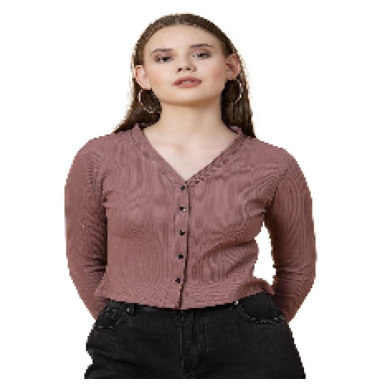

In [53]:
test_img_path = '/kaggle/input/codemonk-test-images/61MuBPxzdxL._SY879_.jpg'
get_predictions(test_img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted article type: Shirts
Predicted colour: Yellow
Predicted gender: Men
Predicted season: Summer


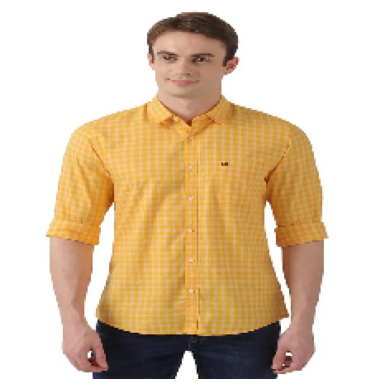

In [54]:
test_img_path = '/kaggle/input/codemonk-test-images/61XTscGYK1L._SY879_.jpg'
get_predictions(test_img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted article type: Tops
Predicted colour: Green
Predicted gender: Women
Predicted season: Summer


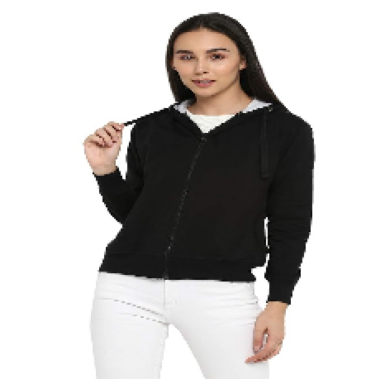

In [55]:
test_img_path = '/kaggle/input/codemonk-test-images/61t965dJIiL._SY879_.jpg'
get_predictions(test_img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted article type: Handbags
Predicted colour: White
Predicted gender: Women
Predicted season: Summer


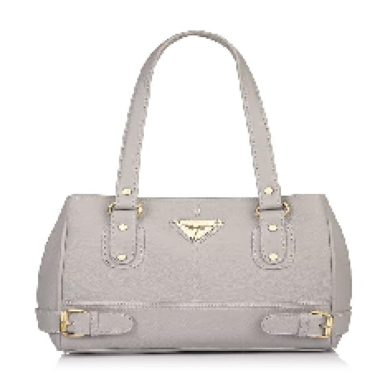

In [56]:
test_img_path = '/kaggle/input/codemonk-test-images/71FGorrevL._SY695_.jpg'
get_predictions(test_img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted article type: Shorts
Predicted colour: Grey
Predicted gender: Men
Predicted season: Fall


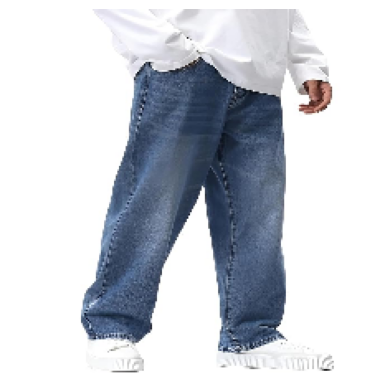

In [57]:
test_img_path = '/kaggle/input/codemonk-test-images/71OBVZ-69WL._SY879_.jpg'
get_predictions(test_img_path)